In [1]:
from model import OrientationWei, sensory_noise_dist
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
model = OrientationWei(sigma_rep=0.01, stim_grid=np.linspace(0, 2*np.pi, 2000), rep_grid=np.linspace(0, 1, 2000))

# Get distribution of estimated thetas for different theta 0s

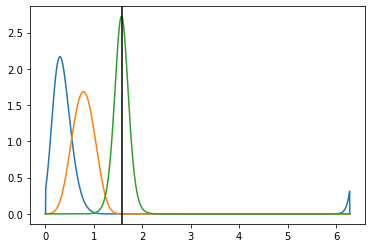

In [3]:
ptheta = model.theta_hat_dist(np.array([0.1*np.pi, 0.25*np.pi, 0.5*np.pi]), sigma_rep=0.03)
plt.plot(model.stim_grid, ptheta.T)
plt.axvline(0.5*np.pi, c='k')

# Make CDFs

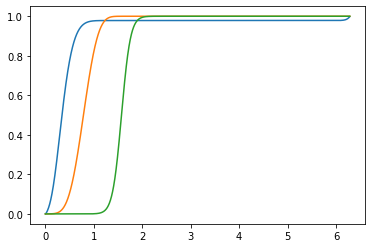

In [4]:
from scipy import integrate
plt.plot(model.stim_grid, integrate.cumtrapz(ptheta, model.stim_grid, initial=0.0).T)

### Use *Race equation*  to figure how likely a sample from one distribution will be bigger than a sample from another dsistribution

In [5]:
# Calculate how often distribution 1 is larger than distribution 2
def diff_dist(grid, p1, p2):
    # grid: 1d
    # p1/p2: n_orienations x n(grid)
    cdf2 = integrate.cumtrapz(p2, grid, initial=0.0, axis=1) 


    # for every grid point, distribution 1 is bigger than distribution 2
    # with a probability of being that value times the probability that dist
    # 2 is lower than that value
    p = p1*cdf2

    # Cummulative probability
    return integrate.trapz(p, grid)

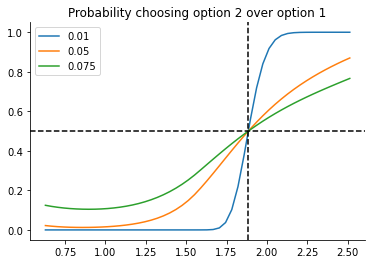

In [6]:
x1 = np.linspace(0.2*np.pi, .8*np.pi)
x2 = np.array([.6*np.pi])

for sigma_rep in [0.01, 0.05, 0.075]:
    ptheta1 = model.theta_hat_dist(x1, sigma_rep=sigma_rep)
    ptheta2 = model.theta_hat_dist(x2, sigma_rep=sigma_rep)

    p_choose1 = diff_dist(model.stim_grid, ptheta1, ptheta2)
    plt.plot(x1, p_choose1, label=sigma_rep)
plt.legend()
plt.title('Probability choosing option 2 over option 1')
sns.despine()
plt.axvline(x2, c='k', ls='--')
plt.axhline(0.5, c='k', ls='--')

In [7]:
def value_function1(x):
    return (20-19*np.abs(np.sin(2*x)))

def get_value_dist(x_stim, p_stim, value_function, bins=20, slow=True):
    x_stim = np.array(x_stim)

    assert(x_stim.ndim == 1), "x_stim should have only one dimension (same grid for all p_stims)"

    # For every bin in x_stim, calculate the probability mass within that bin 
    dx = x_stim[..., 1:] - x_stim[..., :-1]
    p_mass = ((p_stim[..., 1:] + p_stim[..., :-1]) / 2) * dx
    
    # Get the center of every bin
    x_value = value_function(x_stim[:-1] + dx/2.)

    # Now we estimate density by moving every bin to value space and see
    # how much probability mass ends up where in value space using a histogram 
    # (Weightedby the probability masses).

    # Slow implementation for now (Because for looping over distributions)
    if slow:
        ps = []
        for ix in range(len(p_stim)):
            h, edges = np.histogram(x_value, bins=bins, weights=p_mass[ix], density=True)
            ps.append(h)
        
        ps = np.array(ps)
        bin_centers = (edges[1:]+edges[:-1]) / 2

    else:
        # fast implementatiVjon
        # ix = np.repeat(range(p_mass.shape[0]), p_mass.shape[1])
        # x_value_ravel = np.repeat(x_value, p_mass.shape[0])
        # ps, _, edges = np.histogram2d(ix, x_value_ravel, weights=p_mass.ravel(), bins=(np.arange(0,p_mass.shape[0]+1), bins))
        # bin_centers = (edges[1:]+edges[:-1]) / 2
        # d =  np.trapz(ps, bin_centers)
        # ps /= d[:, np.newaxis]
        raise NotImplementedError

    # IDEA: The discrete histogram has some weird holes here and there
    # - a KDE approach would probably be slithgly cleaner

    return bin_centers, ps


# Weird value function

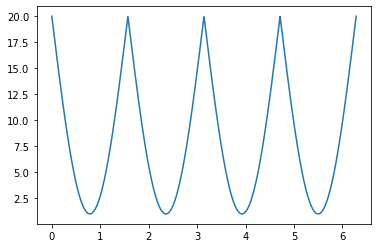

In [8]:
plt.plot(model.stim_grid, value_function1(model.stim_grid))

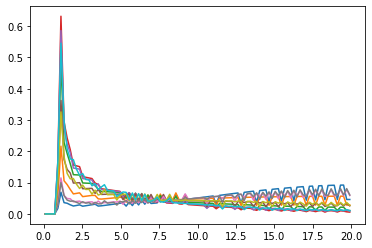

In [9]:
x = np.linspace(0.0*np.pi, .75*np.pi, 50)
ptheta = model.theta_hat_dist(x, sigma_rep=0.05)
x_value, p_value = get_value_dist(model.stim_grid, ptheta, value_function1, bins=np.linspace(0, 20, 100))

plt.plot(x_value[:, np.newaxis], p_value[::5].T)

# value = orientation

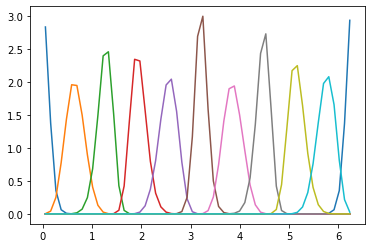

In [10]:
x = np.linspace(0.0*np.pi, 2*np.pi, 50)
ptheta = model.theta_hat_dist(x, sigma_rep=0.025)
x_value, p_value = get_value_dist(model.stim_grid, ptheta, lambda x: x, bins=np.linspace(0, 2*np.pi, 60))

plt.plot(x_value[:, np.newaxis], p_value[::5].T)